In [1]:
import pandas as pd
import numpy as np
import os
import json
import torch
from transformers import BertTokenizer
from model import BertForMultiLabelClassification
from multilabel_pipeline import MultiLabelPipeline

In [2]:
# original, group, ekman
taxonomy = 'original'

In [3]:
df_train = pd.read_csv('./data/' + taxonomy + '/' + 'train.tsv', sep= "\t", header=None, converters={1: str})
df_test = pd.read_csv('./data/' + taxonomy + '/' + 'test.tsv', sep= "\t", header=None, converters={1: str})
df_dev = pd.read_csv('./data/' + taxonomy + '/' + 'dev.tsv', sep= "\t", header=None, converters={1: str})

In [4]:
pd.set_option('display.max_colwidth', None)
df_dev

,0,1,2
0,Is this in New Orleans?? I really feel like this is New Orleans.,27,edgurhb
1,"You know the answer man, you are programmed to capture those codes they send you, don’t avoid them!","4,27",ee84bjg
2,I've never been this sad in my life!,25,edcu99z
3,"The economy is heavily controlled and subsidized by the government. In any case, I was poking at the lack of nuance in US politics today","4,27",edc32e2
4,He could have easily taken a real camera from a legitimate source and change the price in Word/Photoshop and then print it out.,20,eepig6r
...,...,...,...
5421,It's pretty dangerous when the state decides which fictional deity is legitimate. For example the [NAME].....,14,edyrazk
5422,I filed for divorce this morning. Hoping he moves out in the next day or so.,20,edi2z3y
5423,"The last time it happened I just said, ""No"" and closed the door",10,eewbqtx
5424,I can’t stand this arrogant prick he’s no better thenFord in Ontario and that guy is a buffoon,3,eefx57m


In [5]:
train_x = df_train[0].to_list()
test_x = df_test[0].to_list()
dev_x = df_dev[0].to_list()

train_y = df_train[1].to_list()
test_y = df_test[1].to_list()
dev_y = df_dev[1].to_list()

In [6]:
model_dir_dict = {'original':'model/bert-base-uncased-goemotions-original-finetuned', 'ekman':'model/bert-base-uncased-goemotions-ekman-finetuned', 'group':'model/bert-base-uncased-goemotions-group-finetuned'}
model_dir = model_dir_dict[taxonomy]

In [7]:
model_dir

'model/bert-base-uncased-goemotions-original-finetuned'

In [8]:
torch.cuda.is_available()

True

In [9]:
tokenizer = BertTokenizer.from_pretrained(model_dir)
model = BertForMultiLabelClassification.from_pretrained(model_dir)

goemotions = MultiLabelPipeline(
        model=model,
        tokenizer=tokenizer,
        threshold=0.,
        device = 0 if torch.cuda.is_available() else -1
    )

label_list = []
with open(os.path.join("data", taxonomy, "labels.txt"), "r", encoding="utf-8") as f:
    for line in f:
        label_list.append(line.rstrip())

In [10]:
label_list

['admiration',
 'amusement',
 'anger',
 'annoyance',
 'approval',
 'caring',
 'confusion',
 'curiosity',
 'desire',
 'disappointment',
 'disapproval',
 'disgust',
 'embarrassment',
 'excitement',
 'fear',
 'gratitude',
 'grief',
 'joy',
 'love',
 'nervousness',
 'optimism',
 'pride',
 'realization',
 'relief',
 'remorse',
 'sadness',
 'surprise',
 'neutral']

In [11]:
data_x_dict = {'train': train_x, 'test': test_x, 'dev': dev_x}
data_y_dict = {'train': train_y, 'test': test_y, 'dev': dev_y}

data_type = 'test'

data_x = data_x_dict[data_type]
data_y = data_y_dict[data_type]

In [12]:
from sklearn.preprocessing import MultiLabelBinarizer
testing_data_y = []
testing_data_x = []
for idx, i in enumerate(data_y):
    testing_data_x.append(data_x[idx])
    testing_data_y.append(tuple([int(x) for x in i.split(',')]))
multilabelencoder = MultiLabelBinarizer()
testing_data_y = multilabelencoder.fit_transform(testing_data_y)
testing_data_y

array([[0, 0, 0, ..., 1, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1]])

In [13]:
len(testing_data_y)

5427

In [14]:
predicts = []
batch_size = 1000
count_start = 0
count_end = batch_size
data_size = len(testing_data_x)
check = True
while(check):
    if(count_end >= data_size):
        count_end = data_size
        check = False
    print(count_start,count_end)
    testing_data_x_sample = testing_data_x[count_start:count_end]
    testing_data_y_sample = testing_data_y[count_start:count_end]
    predicts += goemotions(testing_data_x_sample)
    count_start += batch_size
    count_end += batch_size

0 1000
1000 2000
2000 3000
3000 4000
4000 5000
5000 5427


In [15]:
len(predicts)

5427

In [16]:
predicts[0]

{'labels': ['admiration',
  'amusement',
  'anger',
  'annoyance',
  'approval',
  'caring',
  'confusion',
  'curiosity',
  'desire',
  'disappointment',
  'disapproval',
  'disgust',
  'embarrassment',
  'excitement',
  'fear',
  'gratitude',
  'grief',
  'joy',
  'love',
  'nervousness',
  'optimism',
  'pride',
  'realization',
  'relief',
  'remorse',
  'sadness',
  'surprise',
  'neutral'],
 'scores': [0.3023537,
  0.32703906,
  0.31518978,
  0.3240127,
  0.31887832,
  0.39896464,
  0.317414,
  0.30912572,
  0.27703688,
  0.31688893,
  0.32620695,
  0.29099214,
  0.28276277,
  0.30462122,
  0.31252834,
  0.30991644,
  0.3929609,
  0.3185283,
  0.5760638,
  0.2890546,
  0.28986543,
  0.2929844,
  0.2972568,
  0.29906216,
  0.5854968,
  0.6270702,
  0.321214,
  0.40425304]}

In [17]:
th = 0.5
predict_y = []
for predict in predicts:
    ans = np.array(predict['scores'])
    ans[ans > th] = 1
    ans[ans != 1] = 0
    predict_y.append(ans)
predict_y = np.array(predict_y)

In [18]:
pd.DataFrame(goemotions(["Thanks for giving advice to the people who need it! 👌🙏"])[0])

,labels,scores
0,admiration,0.344866
1,amusement,0.303256
2,anger,0.314408
3,annoyance,0.333420
4,approval,0.363553
5,caring,0.334161
6,confusion,0.316989
7,curiosity,0.313076
8,desire,0.307223
9,disappointment,0.319463


In [19]:
testing_data_y[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0])

In [20]:
predict_y[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0.], dtype=float32)

In [21]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
results = dict()

results["accuracy"] = accuracy_score(testing_data_y, predict_y)
results["macro_precision"], results["macro_recall"], results["macro_f1"], _ = precision_recall_fscore_support(testing_data_y, predict_y, average="macro")
results["micro_precision"], results["micro_recall"], results["micro_f1"], _ = precision_recall_fscore_support(testing_data_y, predict_y, average="micro")
results["weighted_precision"], results["weighted_recall"], results["weighted_f1"], _ = precision_recall_fscore_support(testing_data_y, predict_y, average="weighted")
results["precision"], results["recall"], results["f1"], _ = precision_recall_fscore_support(testing_data_y, predict_y, average=None)

In [22]:
result_list = []
for idx, label in enumerate(label_list):
    result_list.append([label, results['precision'][idx], results['recall'][idx], results['f1'][idx]])
df_result = pd.DataFrame(result_list)
df_result = df_result.sort_values(by=[0])
df_result = df_result.append({0:'macro-average', 1:results['macro_precision'], 2:results['macro_recall'], 3:results['macro_f1']}, ignore_index=True)
df_result.columns = ['Emotion', 'Precision', 'Recall', 'F1']
df_result

,Emotion,Precision,Recall,F1
0,admiration,0.609467,0.817460,0.698305
1,amusement,0.734139,0.920455,0.816807
2,anger,0.434164,0.616162,0.509395
3,annoyance,0.295374,0.518750,0.376417
4,approval,0.333981,0.490028,0.397229
5,caring,0.343590,0.496296,0.406061
6,confusion,0.293413,0.640523,0.402464
7,curiosity,0.434783,0.774648,0.556962
8,desire,0.583333,0.506024,0.541935
9,disappointment,0.262911,0.370861,0.307692


In [23]:
for idx, predict in enumerate(predicts):
    if(len(predict['labels']) >= 1):
        print("=========================Text=========================")
        print(testing_data_x[idx])
        
        print("========================Predice=======================")
        for predict_idx, predict_score in enumerate(predict['scores']):
            if(predict_score > th):  
                print(label_list[int(predict_idx)], predict_score)
                
        print("======================Ground Truth====================")
        for label_idx, label in enumerate(testing_data_y[idx]):
            if(int(label) == 1):
                print(label_list[label_idx])
        print()

=========================Text=========================
I’m really sorry about your situation :( Although I love the names Sapphira, Cirilla, and Scarlett!
========================Predice=======================
love 0.5760638
remorse 0.5854968
sadness 0.6270702
======================Ground Truth====================
sadness

=========================Text=========================
It's wonderful because it's awful. At not with.
========================Predice=======================
admiration 0.7306483
disgust 0.5294815
======================Ground Truth====================
admiration

=========================Text=========================
Kings fan here, good luck to you guys! Will be an interesting game to watch! 
========================Predice=======================
excitement 0.6086292
optimism 0.70325357
======================Ground Truth====================
excitement

=========================Text=========================
I didn't know that, thank you for teaching me something toda

=========================Text=========================
Ironically, I just sense that they are working in an area where this is a ready stream of revenue just waiting for them.
========================Predice=======================
neutral 0.7674633
======================Ground Truth====================
neutral

=========================Text=========================
My mom used to think [NAME] was the handsomest NFL coach for what that’s worth.
========================Predice=======================
admiration 0.6869652
neutral 0.5593407
======================Ground Truth====================
admiration

=========================Text=========================
No if anything the exact opposite. Couldn’t be further from the truth
========================Predice=======================
neutral 0.80108935
======================Ground Truth====================
neutral

=========================Text=========================
Sorry your right
========================Predice=======================
r

optimism 0.7934951
======================Ground Truth====================
neutral

=========================Text=========================
Some people just need reassurance that they are, in fact, dumb. 
========================Predice=======================
neutral 0.70315075
======================Ground Truth====================
annoyance
fear

=========================Text=========================
Softest fans in sports
========================Predice=======================
neutral 0.71761465
======================Ground Truth====================
neutral

=========================Text=========================
Before the camera was on him, he noticed the atrocious fake jersey on the nimrod beside him. 
========================Predice=======================
neutral 0.79694635
======================Ground Truth====================
neutral

=========================Text=========================
at least it wasn’t the evil [NAME].
========================Predice=======================
rel

neutral 0.68246555
======================Ground Truth====================
neutral

=========================Text=========================
He also lost a QB battle to a 40 year old and rookie "project" QB that everyone thought needed to sit a year pre-draft.
========================Predice=======================
neutral 0.7571722
======================Ground Truth====================
desire

=========================Text=========================
"Freedom is a cage" -[NAME]
========================Predice=======================
neutral 0.8001946
======================Ground Truth====================
neutral

=========================Text=========================
Hope his bare hands are as clean as the griddles. Ready to eat foods need to be handled with gloves . Very cool machine though .
========================Predice=======================
optimism 0.7850957
======================Ground Truth====================
optimism

=========================Text=========================
Yeah I t

disapproval

=========================Text=========================
Dump her. Shes not committed to you
========================Predice=======================
annoyance 0.5425557
disapproval 0.5276806
neutral 0.618931
======================Ground Truth====================
neutral

=========================Text=========================
[NAME] sweetie i’m so sorry
========================Predice=======================
remorse 0.7017739
sadness 0.65318733
======================Ground Truth====================
remorse

=========================Text=========================
His army of Swedish blondes are going to be upset.
========================Predice=======================
disappointment 0.7248965
neutral 0.548613
======================Ground Truth====================
disappointment

=========================Text=========================
>Sorry, but any city that had any kind of ~~epidemic in its~~ history will have bunches of dead people buried under it.
========================Predic

gratitude 0.6472949
neutral 0.543875
======================Ground Truth====================
gratitude

=========================Text=========================
Kinda reminds me of that pluto pic from nasa
========================Predice=======================
neutral 0.75755036
======================Ground Truth====================
realization

=========================Text=========================
You know it doesn't use the word "boycott" at all, right?
========================Predice=======================
curiosity 0.60384476
neutral 0.58511305
======================Ground Truth====================
neutral

=========================Text=========================
This happens to me all the time I’m so sorry 😣 it’s always with burgers, too. So painful. 
========================Predice=======================
remorse 0.5157275
sadness 0.7505936
======================Ground Truth====================
sadness

=========================Text=========================
my good girl
==============

anger 0.73723495
annoyance 0.5334933
======================Ground Truth====================
anger

=========================Text=========================
>Have a good time debating the people in your head, looks like you're having fun.
========================Predice=======================
amusement 0.6025247
joy 0.62622666
======================Ground Truth====================
joy

=========================Text=========================
You're telling me you dont get your meth from there?
========================Predice=======================
curiosity 0.71832776
neutral 0.5612186
======================Ground Truth====================
neutral

=========================Text=========================
[NAME] revealed that's what [NAME] called it at a reunion. [NAME] was backstage with steam coming out his ears 😂
========================Predice=======================
neutral 0.8044342
======================Ground Truth====================
neutral

=========================Text==============

gratitude

=========================Text=========================
My ecology professor hated outdoor cats for that reason. They're extremely destructive animals.
========================Predice=======================
anger 0.7120931
disgust 0.6599207
======================Ground Truth====================
annoyance

=========================Text=========================
Don't doubt yourself. They're wrong.
========================Predice=======================
approval 0.6334555
caring 0.5269481
======================Ground Truth====================
neutral

=========================Text=========================
You love her knowing her limitations, adjusting your expectations, and keeping boundaries firmly set and enforced hard.
========================Predice=======================
love 0.75986624
======================Ground Truth====================
love

=========================Text=========================
When people say [NAME] should be an All star just show them that last poss

realization 0.6177449
======================Ground Truth====================
admiration
optimism

=========================Text=========================
As long as you don't kiss her whole face you will be fine. If you both want it, it shouldn't be awkward.
========================Predice=======================
approval 0.5564776
caring 0.6053252
neutral 0.5934198
======================Ground Truth====================
neutral

=========================Text=========================
Hahahah this is awesome.
========================Predice=======================
admiration 0.61066604
amusement 0.67857707
joy 0.5499235
======================Ground Truth====================
excitement
joy

=========================Text=========================
Fake news! but really, that's awesome to have a parent that actually understands how to teach their child accountability. 
========================Predice=======================
admiration 0.7992542
======================Ground Truth==================

disapproval 0.63030475
neutral 0.5666638
======================Ground Truth====================
neutral

=========================Text=========================
He seemed like he was about to run away and go do some meth.
========================Predice=======================
neutral 0.7987716
======================Ground Truth====================
neutral

=========================Text=========================
Don't know how that was missed. Tragic really. Considering the title.
========================Predice=======================
confusion 0.67846894
disappointment 0.5051306
======================Ground Truth====================
disappointment
sadness

=========================Text=========================
I’m just worried about his attitude and approach with younger players. Edit-re worded
========================Predice=======================
fear 0.61001056
nervousness 0.6304234
======================Ground Truth====================
nervousness

=========================Text======

disapproval 0.7615105
neutral 0.5236868
======================Ground Truth====================
disapproval

=========================Text=========================
That whole [NAME] bit of "I'm not gonna rape you. I'm a little boy." is oddly on target.
========================Predice=======================
neutral 0.77551746
======================Ground Truth====================
neutral

=========================Text=========================
I'm sad for the bot. They only want a purpose
========================Predice=======================
sadness 0.77564526
======================Ground Truth====================
sadness

=========================Text=========================
 Their official logic is that it reduces turn-over, but yeah, the other reasons are kind of obvious.
========================Predice=======================
approval 0.5805127
neutral 0.68700045
======================Ground Truth====================
neutral

=========================Text=========================
I l

surprise 0.67381305
======================Ground Truth====================
neutral

=========================Text=========================
Yeah, I mean it's not like anyone else has ever shut down the Government.
========================Predice=======================
approval 0.6555342
neutral 0.6388621
======================Ground Truth====================
neutral

=========================Text=========================
They are taking advantage of the fact that you found this thread and realized you have to do is one more day until you get it.
========================Predice=======================
realization 0.6104641
neutral 0.70447725
======================Ground Truth====================
realization

=========================Text=========================
Only for a week? You are a great optimist!
========================Predice=======================
admiration 0.7945522
======================Ground Truth====================
curiosity

=========================Text================

======================Ground Truth====================
admiration

=========================Text=========================
I'm glad you have your kids, but have you seen Brooklyn 99 like the op stated? It's worth living for too.
========================Predice=======================
curiosity 0.61048895
joy 0.6284633
======================Ground Truth====================
admiration
confusion
excitement
joy

=========================Text=========================
Right? It’s not like her family seems like they wouldn’t have helped with her son.
========================Predice=======================
neutral 0.66509515
======================Ground Truth====================
disappointment

=========================Text=========================
not sure I agree. whispers of madness can set up [NAME] signature and being card draw is always useful in the first lane.
========================Predice=======================
confusion 0.6102024
disapproval 0.5196218
======================Ground Trut

In [24]:
# only output the scores that are higher than the threshold
goemotions.threshold = th

In [25]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn

colors = seaborn.color_palette("husl", len(label_list))

def plt_result(texts, threshold):
    goemotions.threshold = threshold
    cases = goemotions(texts)
    for text, case in zip(texts,cases):
        print(text)
        # print(case)

        bar = case['scores']
        x = case['labels']
        
        label_color = []
        for i in x:
            label_color.append(colors[label_list.index(i)])

        fig = plt.figure(dpi = 150)
        plt.bar(x, bar, color = label_color)
        plt.ylim(0,1)
        plt.xticks(rotation = 45)
        fig.set_figheight(8)
        fig.set_figwidth(20)
        plt.show()

Thanks for giving advice to the people who need it! 👌🙏


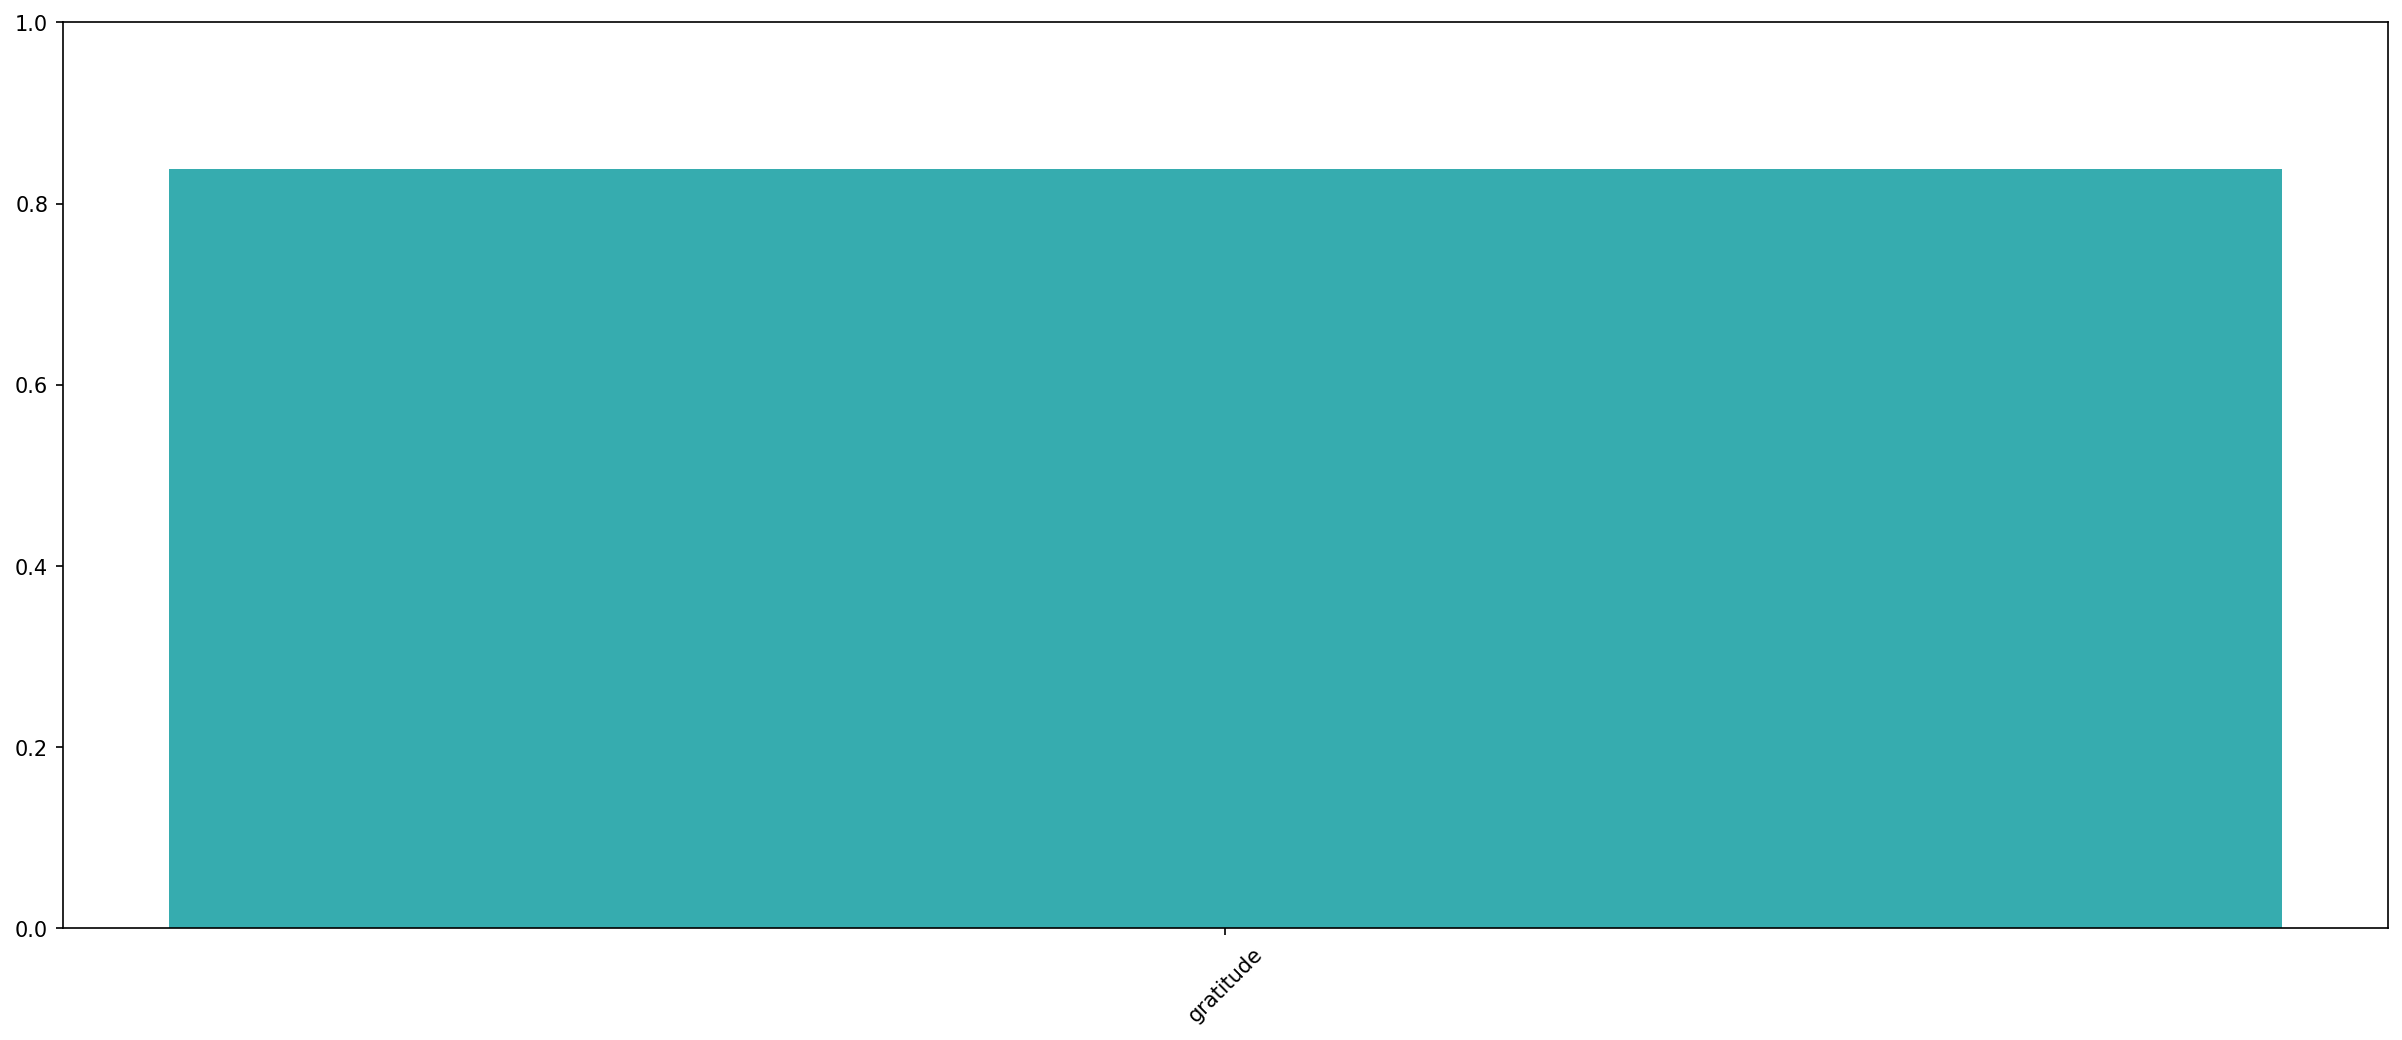

In [26]:
plt_result(["Thanks for giving advice to the people who need it! 👌🙏"], th)

I don't believe it is true


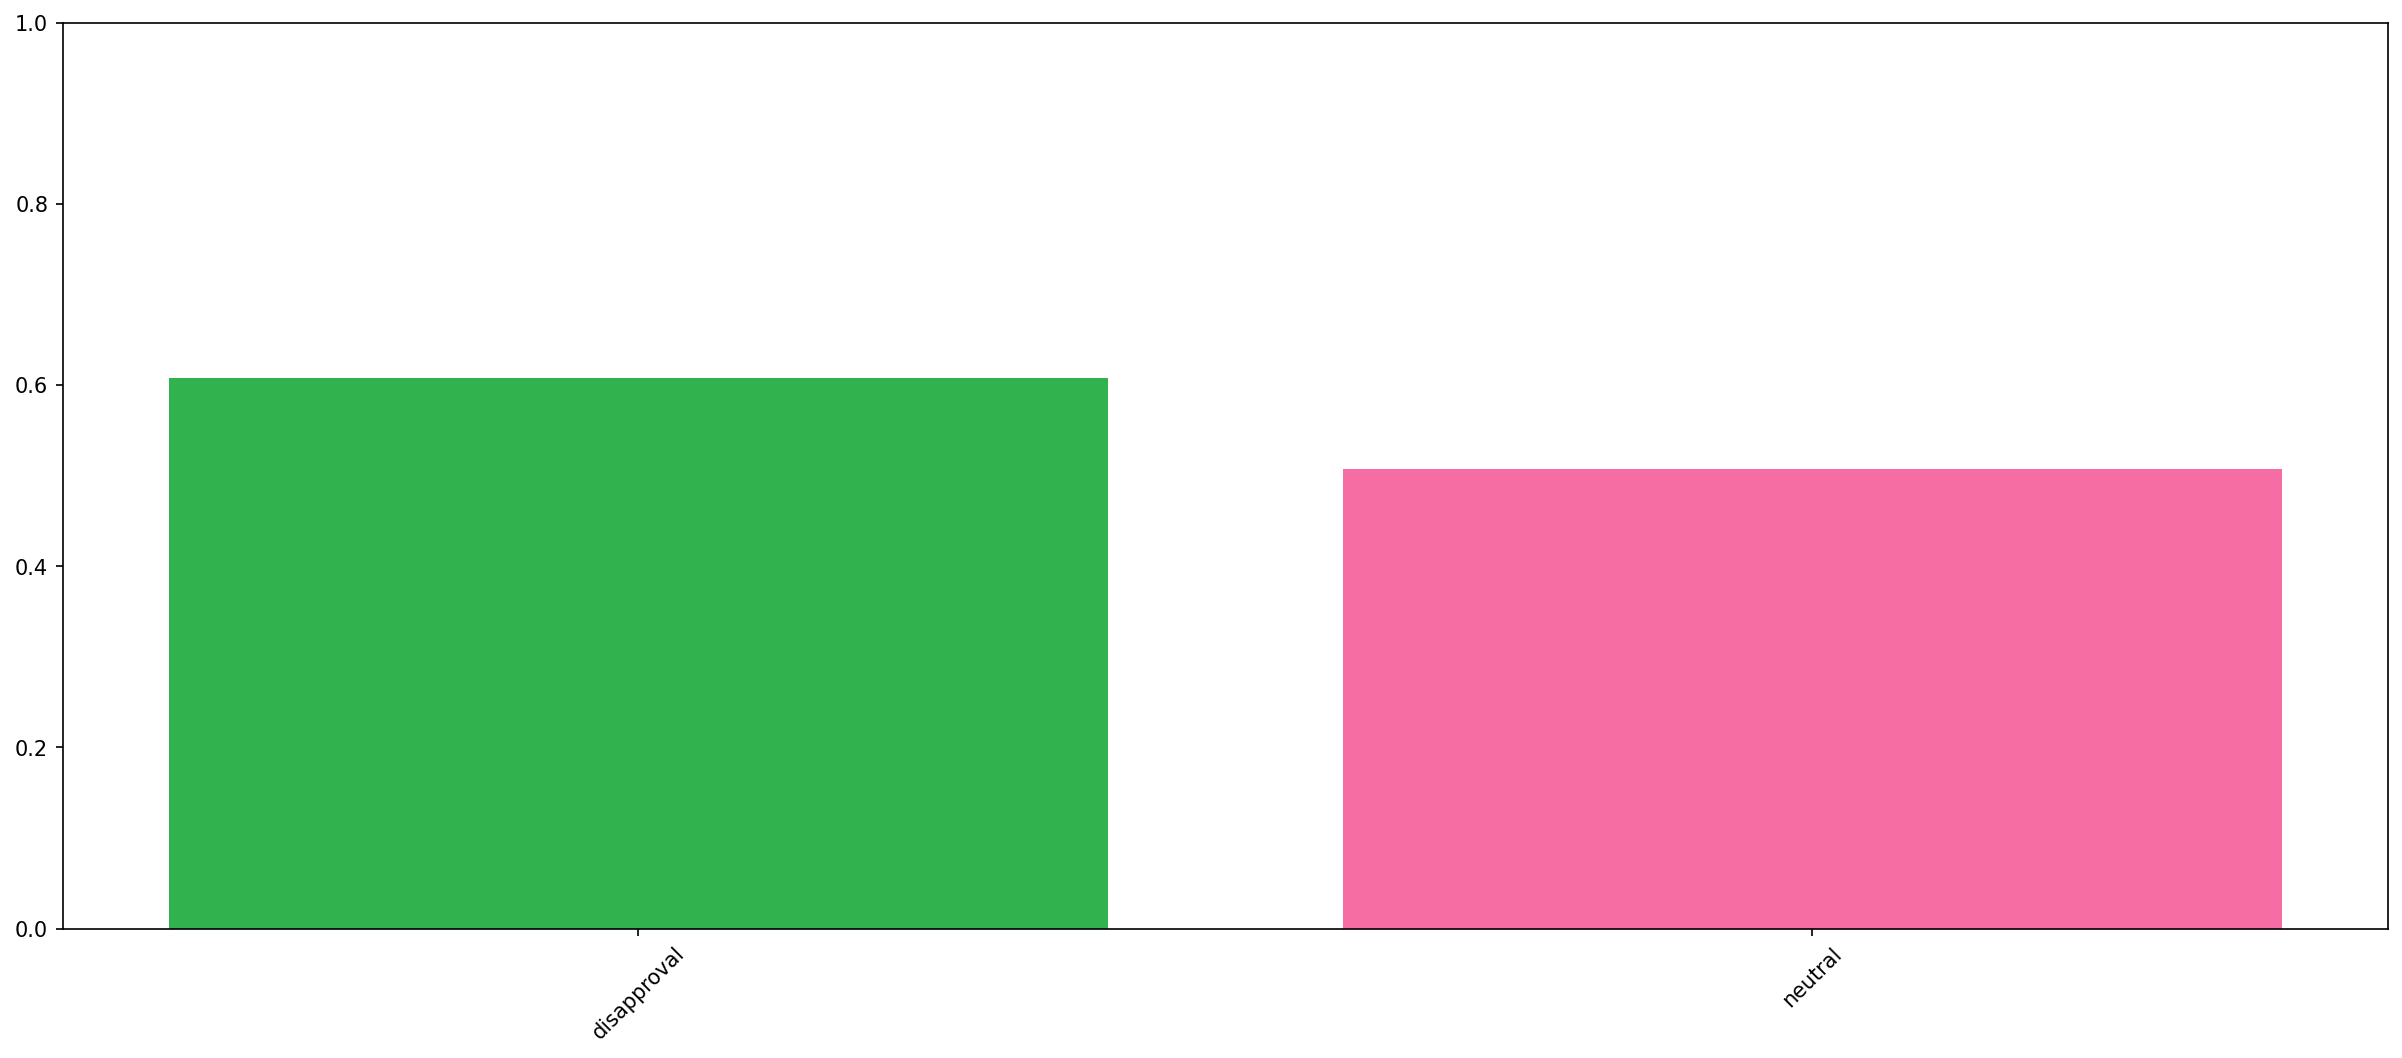

I don't believe it is true. It's really good


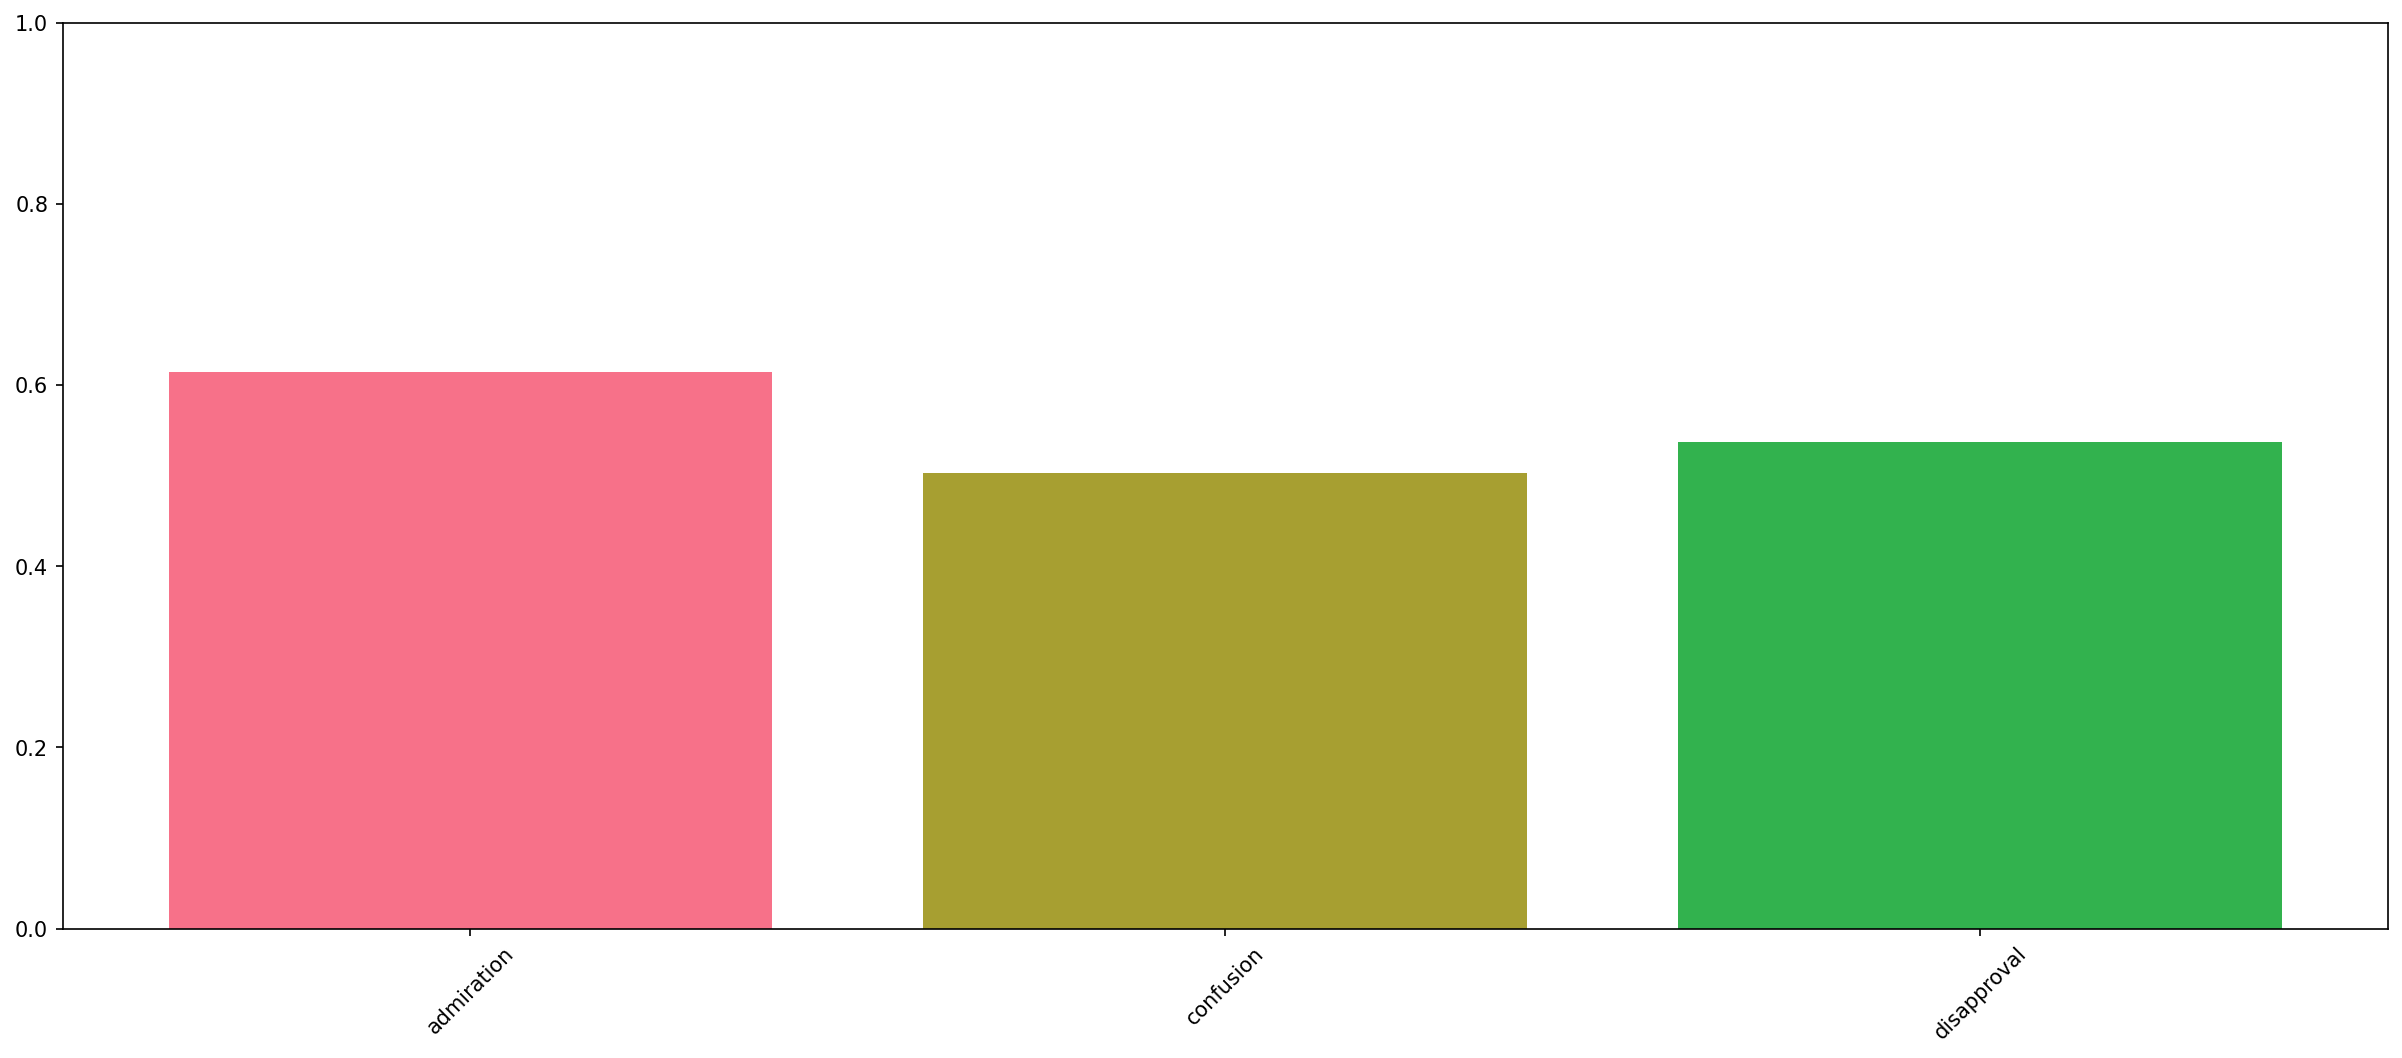

In [27]:
plt_result(["I don't believe it is true", "I don't believe it is true. It's really good"], th)

I don't like you.


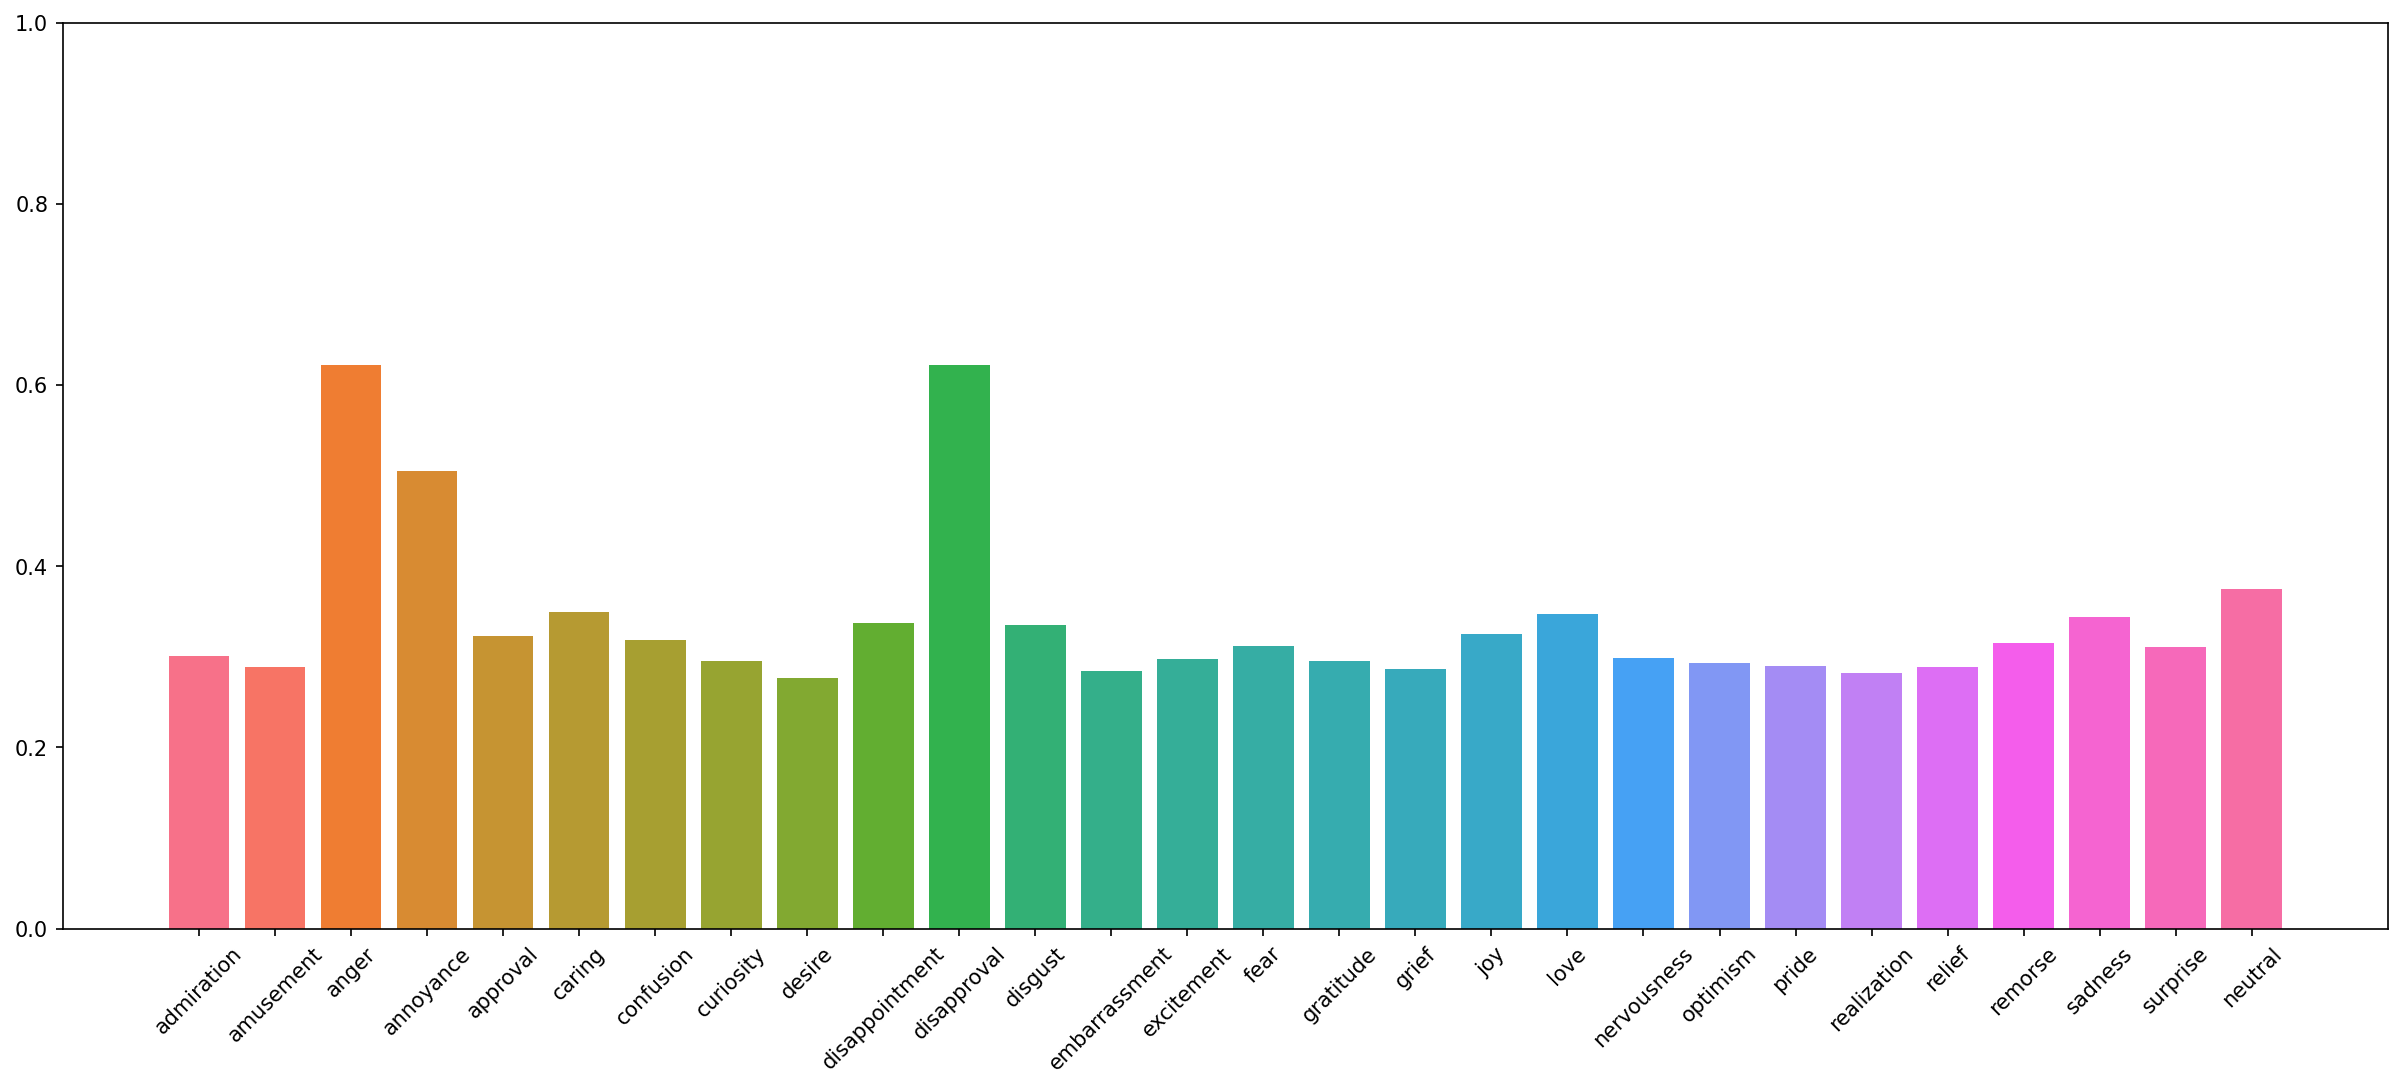

I don't like you. Just kidding haha.


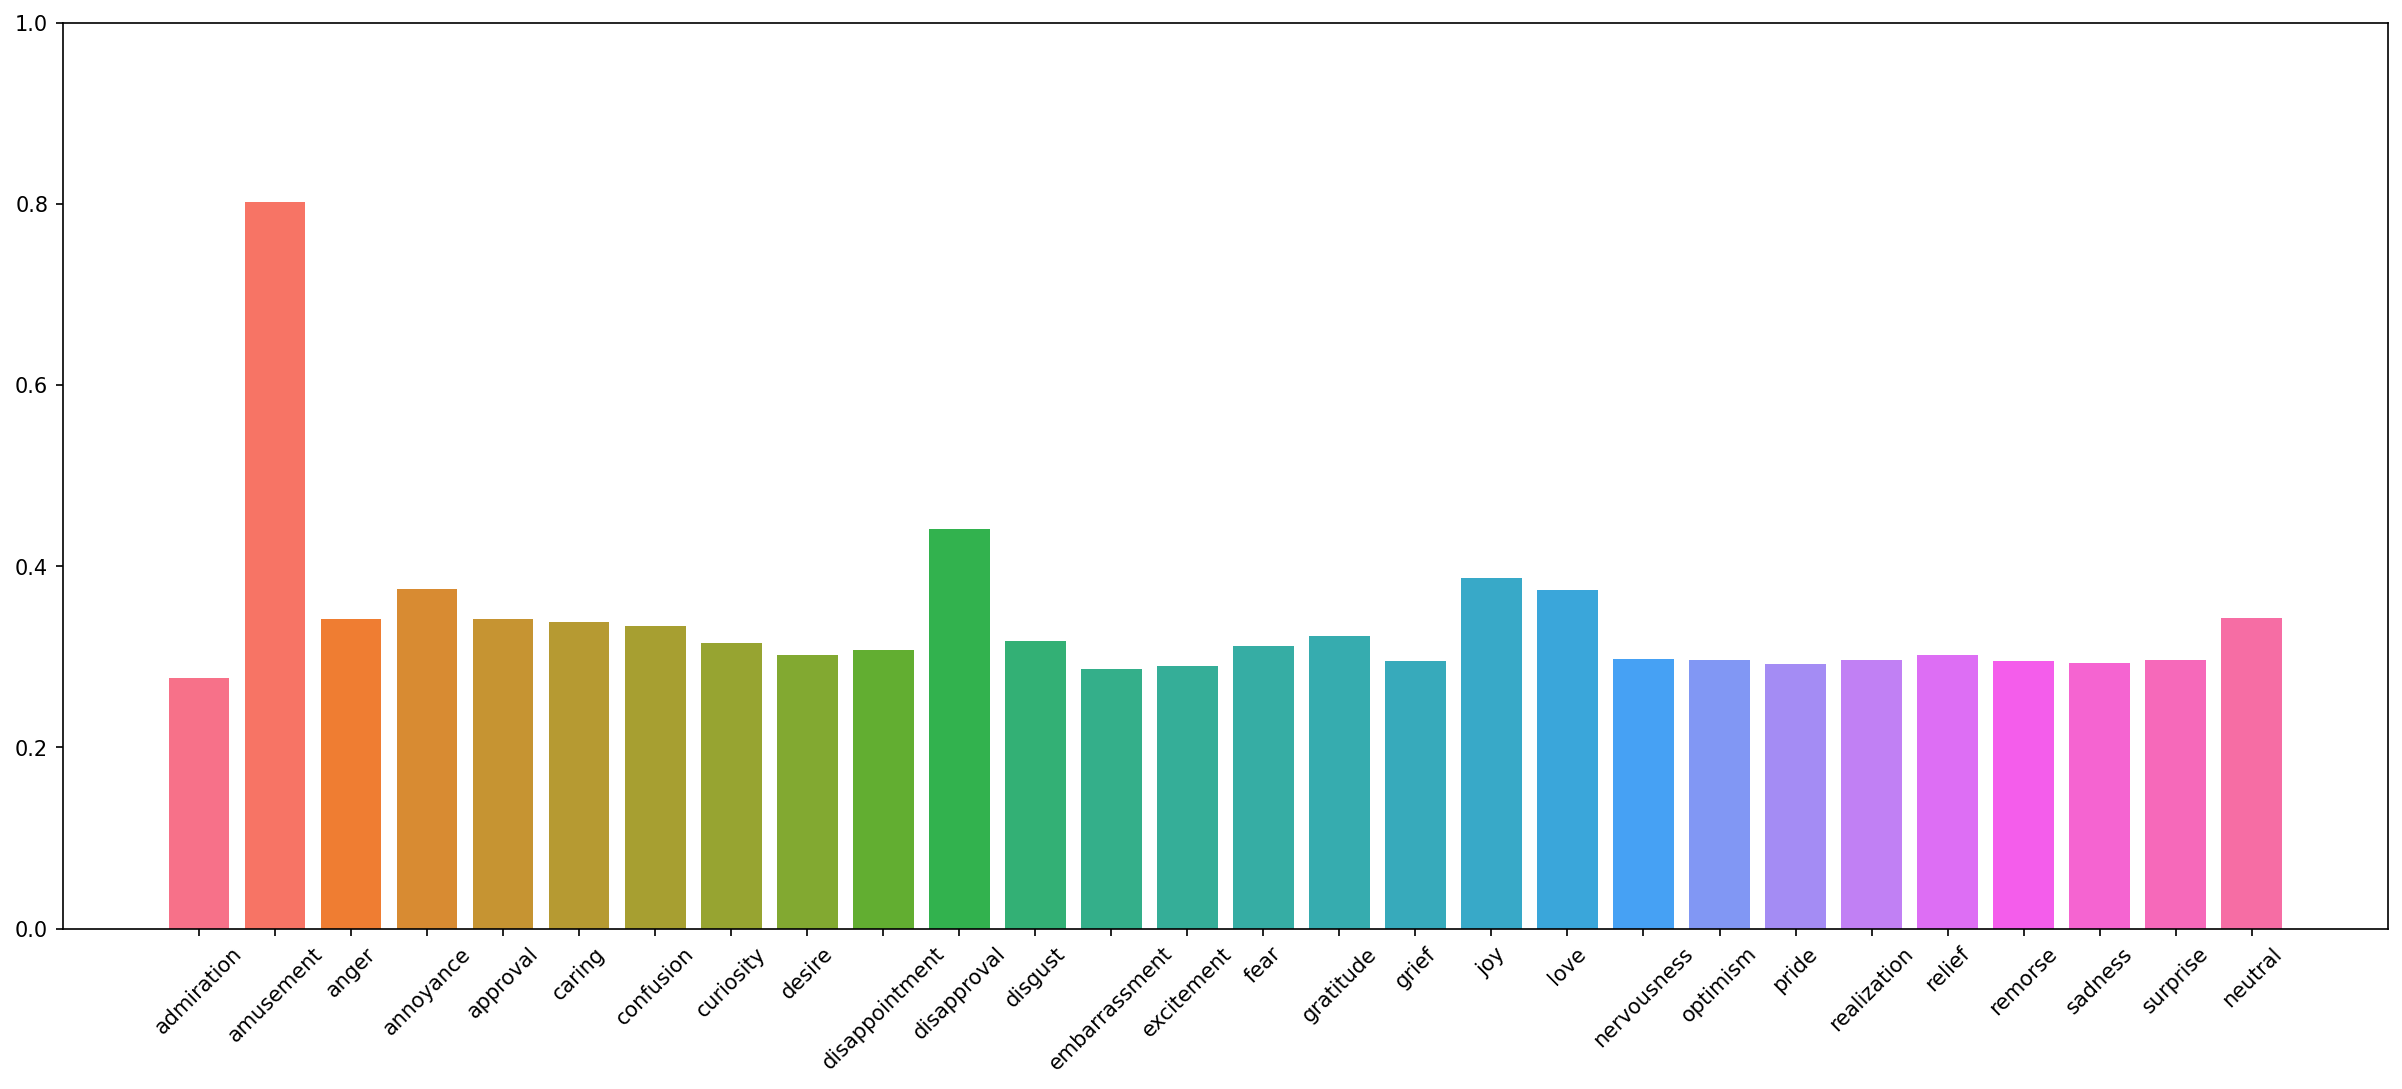

In [28]:
plt_result(["I don't like you.", "I don't like you. Just kidding haha."], 0.)